In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from time import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.stats import ttest_ind
import datetime
import warnings
from ipywidgets import interact, Dropdown, SelectionSlider, widgets
from IPython.display import display, clear_output

import sys, os
sys.path.append(os.path.join(os.getcwd(), 'src/data'))
sys.path.append(os.path.join(os.getcwd(), 'src/utils'))

from results_utils import *
from dataloader_functions import *
from bbdataset_preprocessing import *

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Table of Contents
1. [Load the data](#I.-Load-the-data)
    - [A. Load All Channel Data](#1.-Load-All-Channel-Data)
    - [B. Load Selected Bad Buzz Channel Data](#2.-Load-Selected-Bad-Buzz-Channel-Data)
2. [Data Analysis on Bad Buzz Data](#II.-Data-Analysis-on-Bad-Buzz-Data)
    - [A. Subscribers Analysis](#A.-Subscribers-Analysis)
    - [B. Views Analysis around Detected Bad Buzz](#B.-Views-Analysis-around-Detected-Bad-Buzz)
    - [C. Likes/Dislikes Analysis around Detected Bad Buzz ](#C.-Likes/Dislikes-Analysis-around-Detected-Bad-Buzz)
    - [D. Activity around the BB](#D.-Activity-around-the-BB)
3. [Data Analysis on All Dataset](#III.-Data-Analysis-On-All-Dataset)
    - [Data Processing](#Data-Processing)
    - [A. Various Plots](#A.-Various-Plots)
    - [B. Subscribers Analysis ](#B.-Subscribers-Analysis)
    - [C. Views Analysis around Detected BB](#C.-Views-Analysis-around-Detected-BB)
    - [D. Likes/Dislikes Analysis](#D.-Likes/Dislikes-Analysis)
    - [E. Activity Analysis](#E.-Activity-Analysis)


4. [Conclusion](#conclusion)

# I. Load the data

For each pair of channel and week index we have: 
- `category`: category of the youtube channel
- `views` : Total number of views the channel had this week.
- `delta_views` : Delta views obtained this week.
- `subs` : Total number of subscribers the channel had this week.
- `delta_subs` : Delta subscribers obtained this week.
- `number of videos` : Total number of videos the channel had this week.
- `delta_videos` : Delta videos obtained this week.
- `activity` : number of videos posted this week 
- `view_count` => number of views f viedos posted
- `like_count` => number of likes on pposted video 
- `dislike_count` => number of dislikes on pposted video 

Bad buzz indicators we want to investigate : 
- increase in dislike count 
- drop in subscriber growth or loss of subscribers
- decrease in views or view growth 
- changes in likes/dislikes ratios
- changes in number of videos posted

## 1. Load All Channel Data 

In [2]:
# decomment the next line if we need to update the preprocessed data 
# update_processed_data(verbose=True)
original_data = load_processed_data(verbose=True)

Loading data in chunks of 1000: 100%|█████████▉| 18601/18604.825 [00:33<00:00, 558.49it/s]/opt/anaconda3/envs/ada/lib/python3.11/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Loading data in chunks of 1000: 100%|██████████| 18605/18604.825 [00:33<00:00, 552.33it/s]


Loaded 18604824 rows


In [3]:
nb_channels = original_data.reset_index()['channel'].nunique()
print(f'Number of channels : {nb_channels}')
print(f'Columns name :\n {original_data.columns}')

Number of channels : 133516
Columns name :
 Index(['category', 'views', 'delta_views', 'subs', 'delta_subs', 'videos',
       'delta_videos', 'activity', 'view_count', 'like_count',
       'dislike_count'],
      dtype='object')


In [4]:
min_week_index_original = original_data.reset_index()['week'].min()
max_week_index_original = original_data.reset_index()['week'].max()

print(f'The minimum week index is {min_week_index_original} and corresponds to the date : {week_index_to_date(min_week_index_original)}')
print(f'The maximum week index is {max_week_index_original} and corresponds to the date : {week_index_to_date(max_week_index_original)}')

The minimum week index is 0 and corresponds to the date : 2015-01-05 00:00:00
The maximum week index is 247 and corresponds to the date : 2019-09-30 00:00:00


## 2. Load Selected Bad Buzz Channel Data 

This dataset only contains channels that are known to have had bad buzz during the period covered by the YouNiverse dataset.

In [5]:
# decomment the next line if we need to update the preprocessed data 
# update_processed_bb_timeseries(verbose=True)
data = load_bb_timeseries_processed(verbose=True)

Loading data in chunks of 1000: 6it [00:00, 331.02it/s]                  

Loaded 5030 rows


In [6]:
nb_channels = data.reset_index()['channel'].nunique()
print(f'Number of channels : {nb_channels}')
print(f'Columns name :\n {data.columns}')

Number of channels : 33
Columns name :
 Index(['category', 'views', 'delta_views', 'subs', 'delta_subs', 'videos',
       'delta_videos', 'activity', 'view_count', 'like_count',
       'dislike_count'],
      dtype='object')


In [7]:
min_week_index = data.reset_index()['week'].min()
max_week_index = data.reset_index()['week'].max()

print(f'The minimum week index is {min_week_index} and corresponds to the date : {week_index_to_date(min_week_index)}')
print(f'The maximum week index is {max_week_index} and corresponds to the date : {week_index_to_date(max_week_index)}')

The minimum week index is 91 and corresponds to the date : 2016-10-03 00:00:00
The maximum week index is 247 and corresponds to the date : 2019-09-30 00:00:00


# II. Data Analysis On BB Data

## A. Subscribers Analysis
The first step of our analysis is to detect the sudden subscriber losses.

### 1. Plot for each channel the evolution of the number of subscribers

In [8]:
# Create a SelectionSlider widget for selecting channels
channel_selector = SelectionSlider(
    options=data.index.get_level_values('channel').unique(),
    description='Channel:',
    disabled=False
)

In [9]:
interactive_plot_subs = widgets.interactive_output(plot_subs_by_channel, {'channel': channel_selector, 'df': widgets.fixed(data)})
display(channel_selector, interactive_plot_subs)

SelectionSlider(description='Channel:', options=('UC-lHJZR3Gqxm24_Vd_AJ5Yw', 'UC0v-tlzsn0QZwJnkiaUSJVQ', 'UC1r…

Output()

After plotting the evolution of the number of subscribers of these Youtube channels, we notice that most of them never have a decreasing number of subscribers, even though we know they all went through at least one bad buzz.

### 2. Rolling average analysis
Since the big YouTube channels in our dataset typically experience consistent subscriber growth, they rarely face actual decreases in their total subscriber count. However, a significant slowdown in the growth rate can still be considered a negative event, as it may indicate potential issues such as reduced engagement or a negative reception by the audience. To detect these sharp declines in subscriber growth, we compare the actual growth rate (`delta_subs`) against the rolling average growth rate (`rolling_growth_rate`).\
The rolling average acts as a smoothed baseline, calculated using a defined window (we arbitrarily used a `ROLLING_WINDOW` of 20 weeks), which helps to identify deviations from the expected trend. When the actual growth rate falls below the rolling average, it suggests that the channel's performance has dipped relative to its typical trend. This comparison enables us to highlight periods of concern where the channel's momentum weakens, which could signal the start of a "bad buzz" or other negative factors impacting channel performance.

In [10]:
ROLLING_WINDOW = 20

data['rolling_growth_rate'] = data.groupby('channel')['delta_subs'].transform(lambda x: x.rolling(ROLLING_WINDOW, min_periods=1).mean())
data['growth_diff'] = data['delta_subs'] - data['rolling_growth_rate']

# Detection of period where growth_rate < rolling_growth_rate
data['is_bad_buzz'] = data['growth_diff'] < 0
# Create a DataFrame that contains only the starting week of each BBC
bad_buzz_starts = []

# For loop to detect the starting week of BB
for channel in data.reset_index()['channel'].unique():
    channel_data = data.reset_index()[data.reset_index()['channel'] == channel]
    
    # Identify indices where BB has started
    for i in range(1, len(channel_data)):
        if channel_data['is_bad_buzz'].iloc[i] and not channel_data['is_bad_buzz'].iloc[i-1]:
            bad_buzz_starts.append({'channel': channel, 'week': channel_data['week'].iloc[i]})

bad_buzz_df = pd.DataFrame(bad_buzz_starts).reset_index()[['channel', 'week']]

max_nb_bb = bad_buzz_df.groupby('channel').count()['week'].max()
print(f'A channel has a maximum of {max_nb_bb}')

bad_buzz_df

A channel has a maximum of 22


,channel,week
0,UC-lHJZR3Gqxm24_Vd_AJ5Yw,95
1,UC-lHJZR3Gqxm24_Vd_AJ5Yw,104
2,UC-lHJZR3Gqxm24_Vd_AJ5Yw,112
3,UC-lHJZR3Gqxm24_Vd_AJ5Yw,130
4,UC-lHJZR3Gqxm24_Vd_AJ5Yw,137
...,...,...
499,UCzKc6JrWSt_67UpEYIefrJQ,182
500,UCzKc6JrWSt_67UpEYIefrJQ,188
501,UCzKc6JrWSt_67UpEYIefrJQ,198
502,UCzKc6JrWSt_67UpEYIefrJQ,205


In order to get the periods of concern, we save in the dataframe `bad_buzz_df` the first week index of the period where growth_rate < rolling_growth_rate.

In [11]:
interactive_plot_subs_roll_avg = widgets.interactive_output(plot_rolling_growth_rate, {'channel': channel_selector,
                                                                                       'df': widgets.fixed(data), 
                                                                                       'bad_buzz_df': widgets.fixed(bad_buzz_df),
                                                                                       'event_name': widgets.fixed("Bad Buzz")})
display(channel_selector, interactive_plot_subs_roll_avg)

SelectionSlider(description='Channel:', options=('UC-lHJZR3Gqxm24_Vd_AJ5Yw', 'UC0v-tlzsn0QZwJnkiaUSJVQ', 'UC1r…

Output()

Now that we detected periods of concern that are potential "bad buzz", we want to see if the change of growth rate correlates with other engagement metrics or events. Specifically, we aim to identify relationships between these slowdowns in subscriber growth and various possible influencing factors such as:
- Number of views
- Like/Dislike ratio
- Activity

## B. Views Analysis around Detected Bad Buzz 
During this part of the analysis, we want to visualize changes in views around the periods of interest detected previously, to explore the behavior of `delta_views` around the identified periods for each YouTube channel.\
We use the `define_periods` function to divide the data into:
- Pre-buzz: 10 weeks leading up to the bad buzz event.
- During-buzz: The 10-week period starting from the bad buzz week.
- Post-buzz: The following 10 to 20 weeks post-buzz.


### 1. Delta Views Evolution

In [12]:
interactive_plot_views = widgets.interactive_output(plot_views_around_bad_buzz, {'channel': channel_selector, 
                                                                                'df': widgets.fixed(data), 
                                                                                'bad_buzz_df': widgets.fixed(bad_buzz_df)})
display(channel_selector, interactive_plot_views)

SelectionSlider(description='Channel:', options=('UC-lHJZR3Gqxm24_Vd_AJ5Yw', 'UC0v-tlzsn0QZwJnkiaUSJVQ', 'UC1r…

Output()

### 2. One Channel

For the pre-buzz, during-buzz, and post-buzz periods of each detected period, we compute the average `delta_views` and perform a t-test to determine if the change in views during the bad buzz is statistically significant compared to the pre-buzz period. The `analyze_views_around_bad_buzz` function iterates over each detected bad buzz week, to analyze how delta_views changed around these periods.

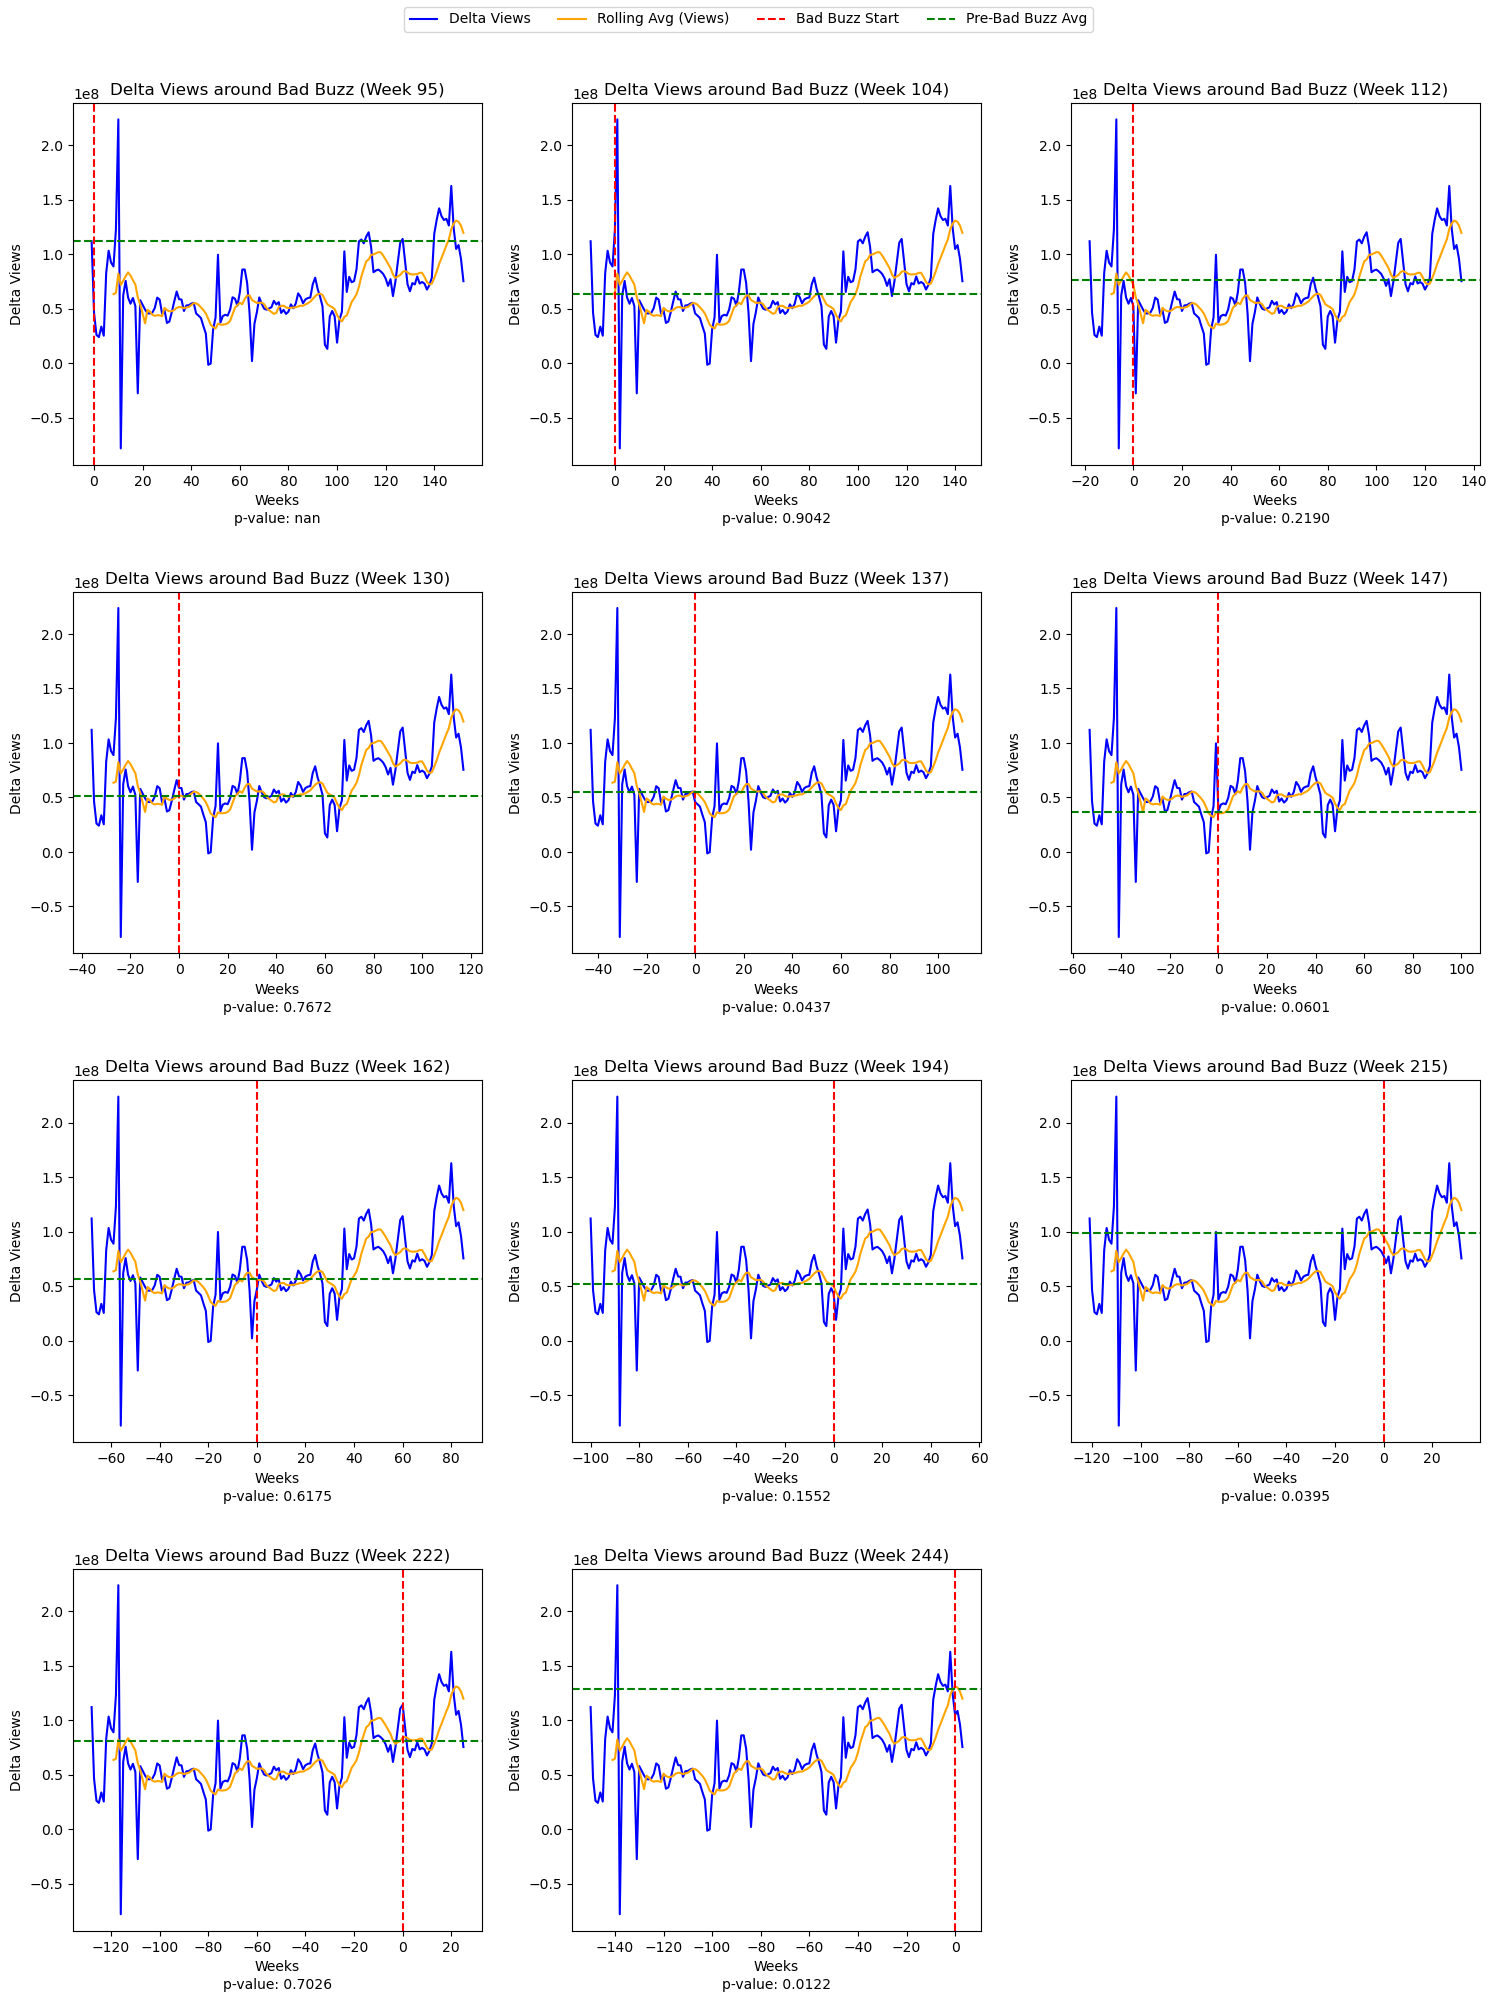

In [13]:
pew_die_pie = data.xs('UC-lHJZR3Gqxm24_Vd_AJ5Yw', level='channel').reset_index()
pew_die_pie_bb_weeks = bad_buzz_df[bad_buzz_df['channel'] == 'UC-lHJZR3Gqxm24_Vd_AJ5Yw']['week']

fig, axes = plt.subplots(4, 3, figsize=(15, 20))

axes = axes.flatten()

for i, week in enumerate(pew_die_pie_bb_weeks):
    df_plot = normalize_week_indices(pew_die_pie, week)
    pre_buzz, during_buzz, post_buzz = define_periods(df_plot)
    avg_pre_buzz_views, avg_during_buzz_views, avg_post_buzz_views = calculate_averages(pre_buzz, during_buzz, post_buzz)
    
    p_value = perform_t_test(pre_buzz, during_buzz)
    
    plot_results(axes[i], df_plot, avg_pre_buzz_views, week, p_value, event_name="Bad Buzz")
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


fig.legend(*axes[0].get_legend_handles_labels(), loc='upper center', ncol=4)

plt.tight_layout()
plt.subplots_adjust(hspace=0.35, top=0.95)
plt.show()

### 3. All Channels 

In [14]:
interactive_plot_views_roll_avg = widgets.interactive_output(analyze_views_around_bad_buzz, {'channel': channel_selector, 
                                                                                            'df': widgets.fixed(data),
                                                                                            'bad_buzz_df': widgets.fixed(bad_buzz_df),
                                                                                            'event_name': widgets.fixed("Bad Buzz")})
display(channel_selector, interactive_plot_views_roll_avg)

SelectionSlider(description='Channel:', options=('UC-lHJZR3Gqxm24_Vd_AJ5Yw', 'UC0v-tlzsn0QZwJnkiaUSJVQ', 'UC1r…

Output()

Only a few of the detected periods of interest seem to be correlated with a significant change of views.\
We hypothesize the following:

- **Loss of Interest**: When audience engagement decreases due to a gradual loss of interest or content fatigue, we expect a sustained decrease in delta_views. This pattern reflects a natural decline in audience engagement without significant external attention. In this case, we are not expecting an important change between the `delta_views` averages of the `pre_buzz` and the `during_buzz` periods. It could be interesting to further explore this option by comparing the `pre_buzz` and `post_buzz` averages.

- **Bad Buzz Event**: Conversely, when audience loss is triggered by a negative event (e.g., public backlash or negative media coverage), we hypothesize that there will be an initial temporary spike in views. This increase results from heightened public interest or curiosity, as viewers seek to understand or react to the controversy.

It is possible that the events with a low p-value are the ones corresponding to bad buzz events, when the other ones correspond to a loss of interest and therefore don't have any drastic change of viewership.

The approach used in this part helps us understand whether significant shifts in views occur around the identified bad buzz periods.

## C. Likes/Dislikes Analysis Around Detected Bad Buzz

After investigating the number of views, we would now like to see if the number dislikes increase and if the number of likes decreases when a channel has a sudden drop of growth.

- 1. Normalize the timeline around each identified bad buzz event
- 2. Compare metrics for pre-buzz, during-buzz, and post-buzz periods:
    - Pre-Buzz: Let's say the 10 weeks leading up to the bad buzz
    - During Buzz: The week of the bad buzz and the 9 weeks following it
    - Post-Buzz: The 10 weeks after the initial bad buzz period\
Key metrics:
    - like_count: The number of likes received during a specific week
    - dislike_count: The number of dislikes received during a specific week
    - Like/Dislike Ratio: Calculated as like_count / (like_count + dislike_count)

- 3. Hypothesis Testing
    - Hypothesis: During a bad buzz, dislike_count should increase, and like_count or the like/dislike ratio should decrease
You can verify this by comparing averages and performing statistical tests to see if there’s a significant change in these metrics during the bad buzz period compared to the pre-buzz period.

### 1. One Channel 

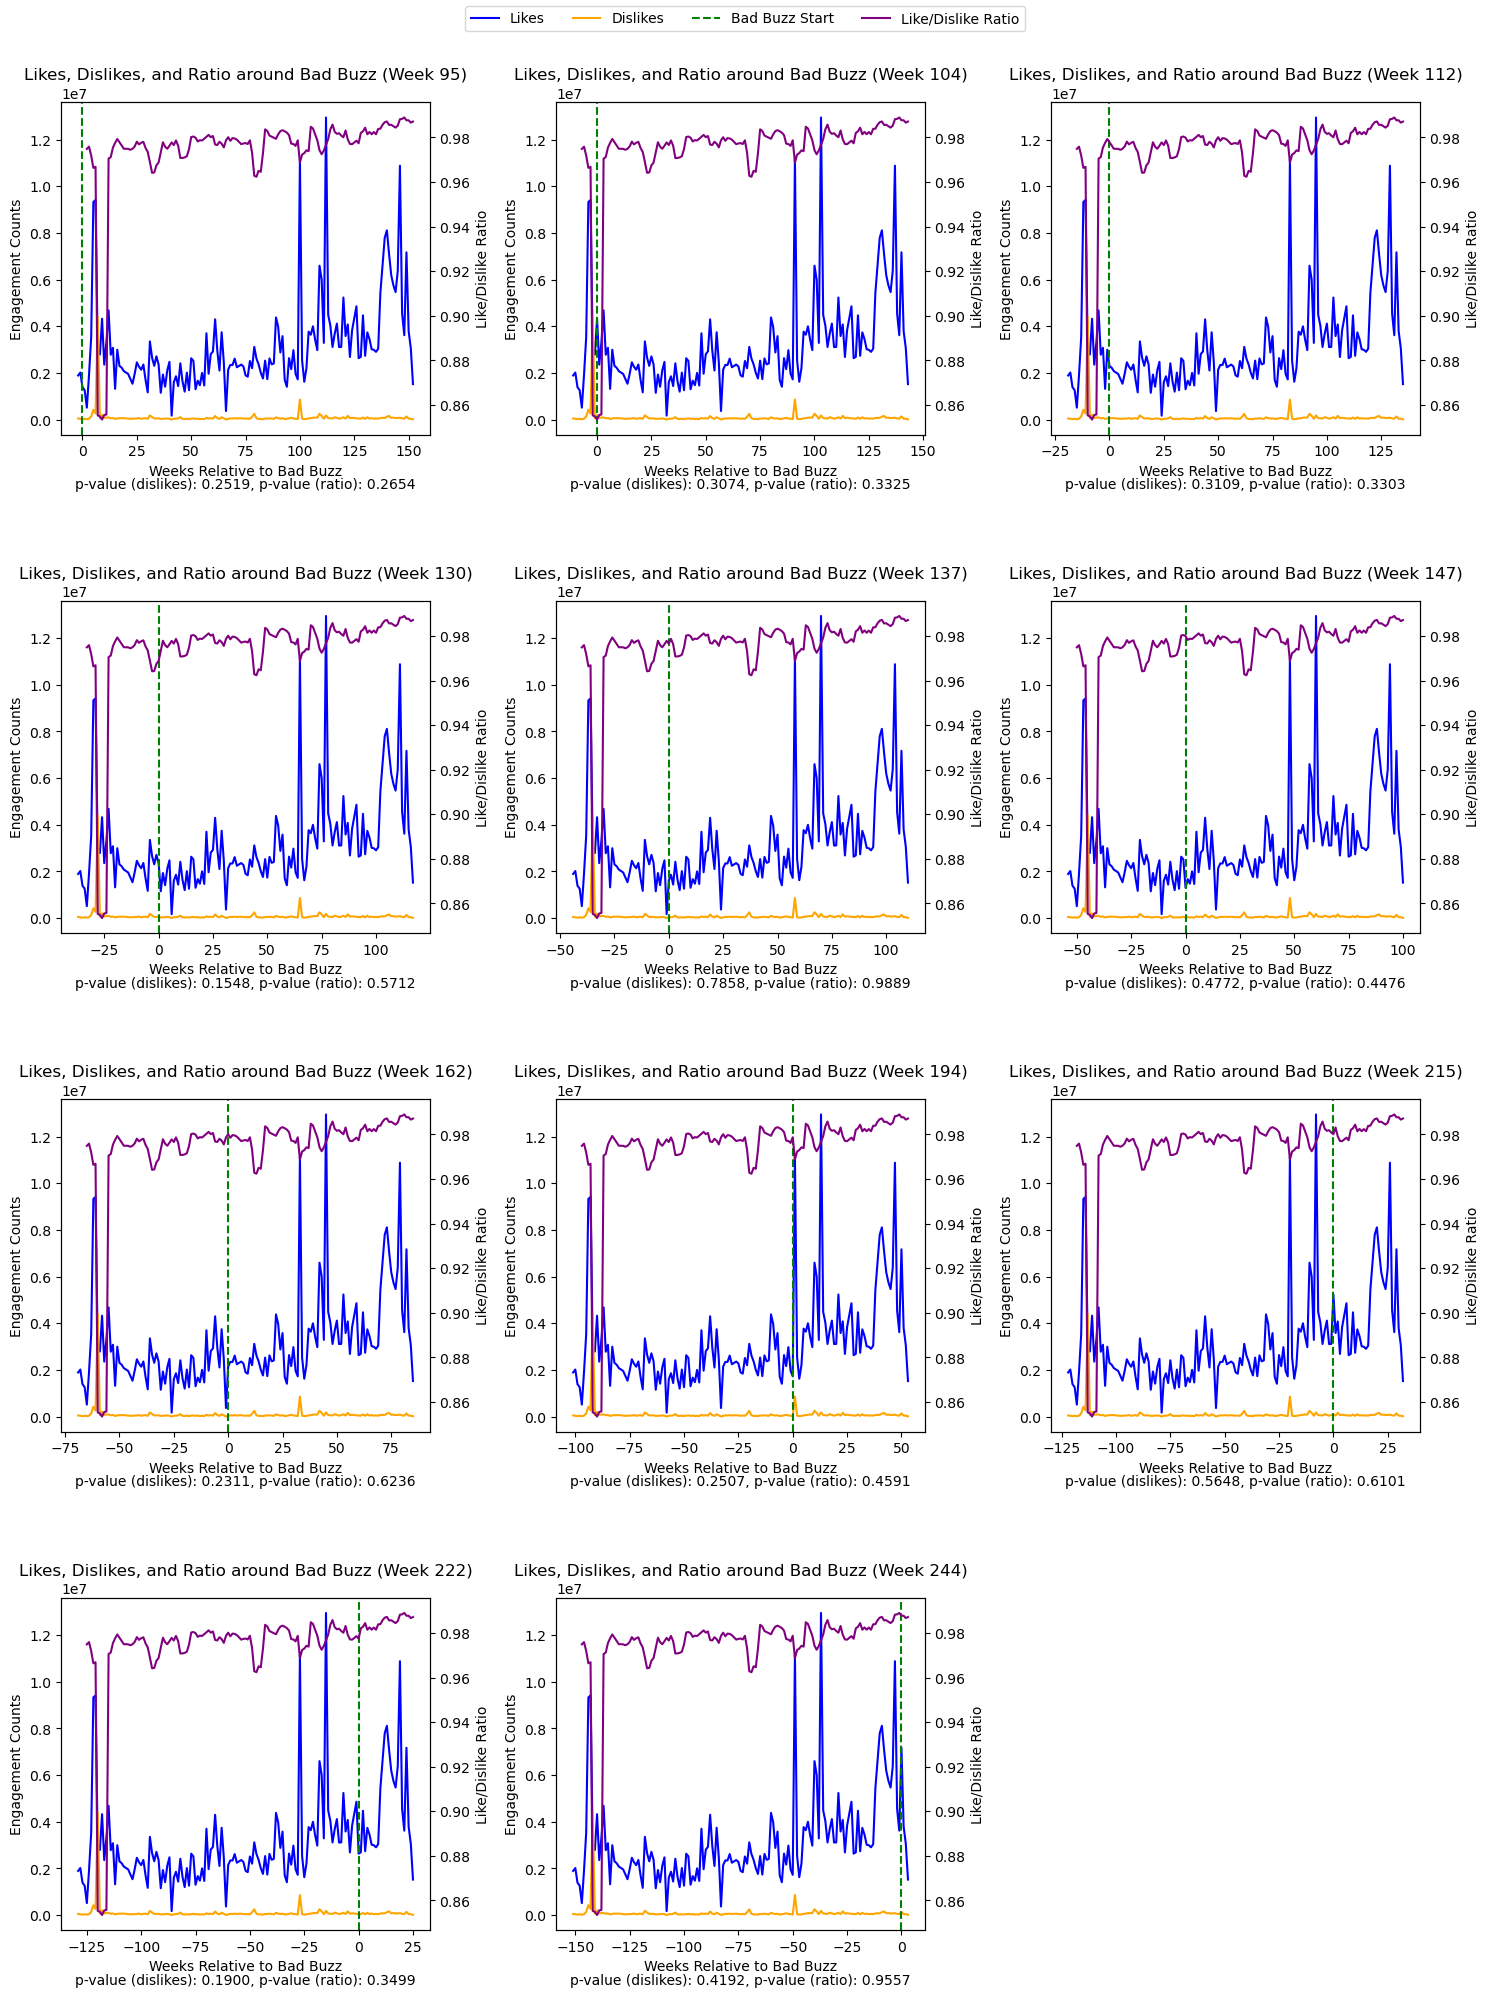

In [15]:
fig, axes = plt.subplots(4, 3, figsize=(15, 20))

axes = axes.flatten()

for i, week in enumerate(pew_die_pie_bb_weeks):
    df_plot = normalize_week_indices(pew_die_pie, week)
    pre_buzz, during_buzz, post_buzz = define_periods(df_plot)
    avg_pre_likes, avg_pre_dislikes, avg_pre_ratio, avg_during_likes, avg_during_dislikes, avg_during_ratio = calculate_engagement_averages(pre_buzz, during_buzz)
    
    p_value_dislikes, p_value_ratio = perform_engagement_t_tests(pre_buzz, during_buzz)
    
    plot_engagement_results(axes[i], df_plot, week, p_value_dislikes, p_value_ratio)
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
lines, labels = axes[0].get_legend_handles_labels()
fig.legend(lines + [plt.Line2D([0], [0], color="purple", lw=1.5)], labels + ["Like/Dislike Ratio"], loc='upper center', ncol=4)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, top=0.95)
plt.show()

Some of the periods of interest seem be correlated with a drop of the Like/Dislike ratio, for example the ones that happen during week 104 or week 194.
We can hypothesize that in the case of a lost of interest, the Like/Dislike ratio of the channel doesn't change significantly. On the other side, if a channel has a bad buzz event, it will probably coincide with a lower Like/Dislike ratio that reflects the change of the public's opinion on the channel.\
It is possible that the events with a low p-value are the ones corresponding to bad buzz events, when the other ones correspond to a loss of interest and therefore don't have any drastic change of viewership. In the example plotted above, all the p-values are high, suggesting that the changes of Like/Dislike ratio of the periods of interest shown are not statistically significant. Since we can see some correlation on the graphs, maybe we could investigate further and try different `pre_buzz`, `during_buzz`and `post_buzz` periods.

### 2. All Channels 

In [16]:
# TODO Checker explication des grandes p-values au-dessus
interactive_plot_likes_dislikes = widgets.interactive_output(analyze_engagement_around_bad_buzz, {'channel': channel_selector, 
                                                                                   'df': widgets.fixed(data), 
                                                                                   'bad_buzz_df': widgets.fixed(bad_buzz_df)})
display(channel_selector, interactive_plot_likes_dislikes)

SelectionSlider(description='Channel:', options=('UC-lHJZR3Gqxm24_Vd_AJ5Yw', 'UC0v-tlzsn0QZwJnkiaUSJVQ', 'UC1r…

Output()

## D. Activity around the BB 
In this part, we want to see if the activity of a youtube channel and its growth are correlated.\
Two hypotheses:
- An activity lower than usual could induce a down-turn of the channel growth
- A period of slower growth could be followed by a high- or low- activity, depending on the strategy of the youtube channel

### 1. For One Channel

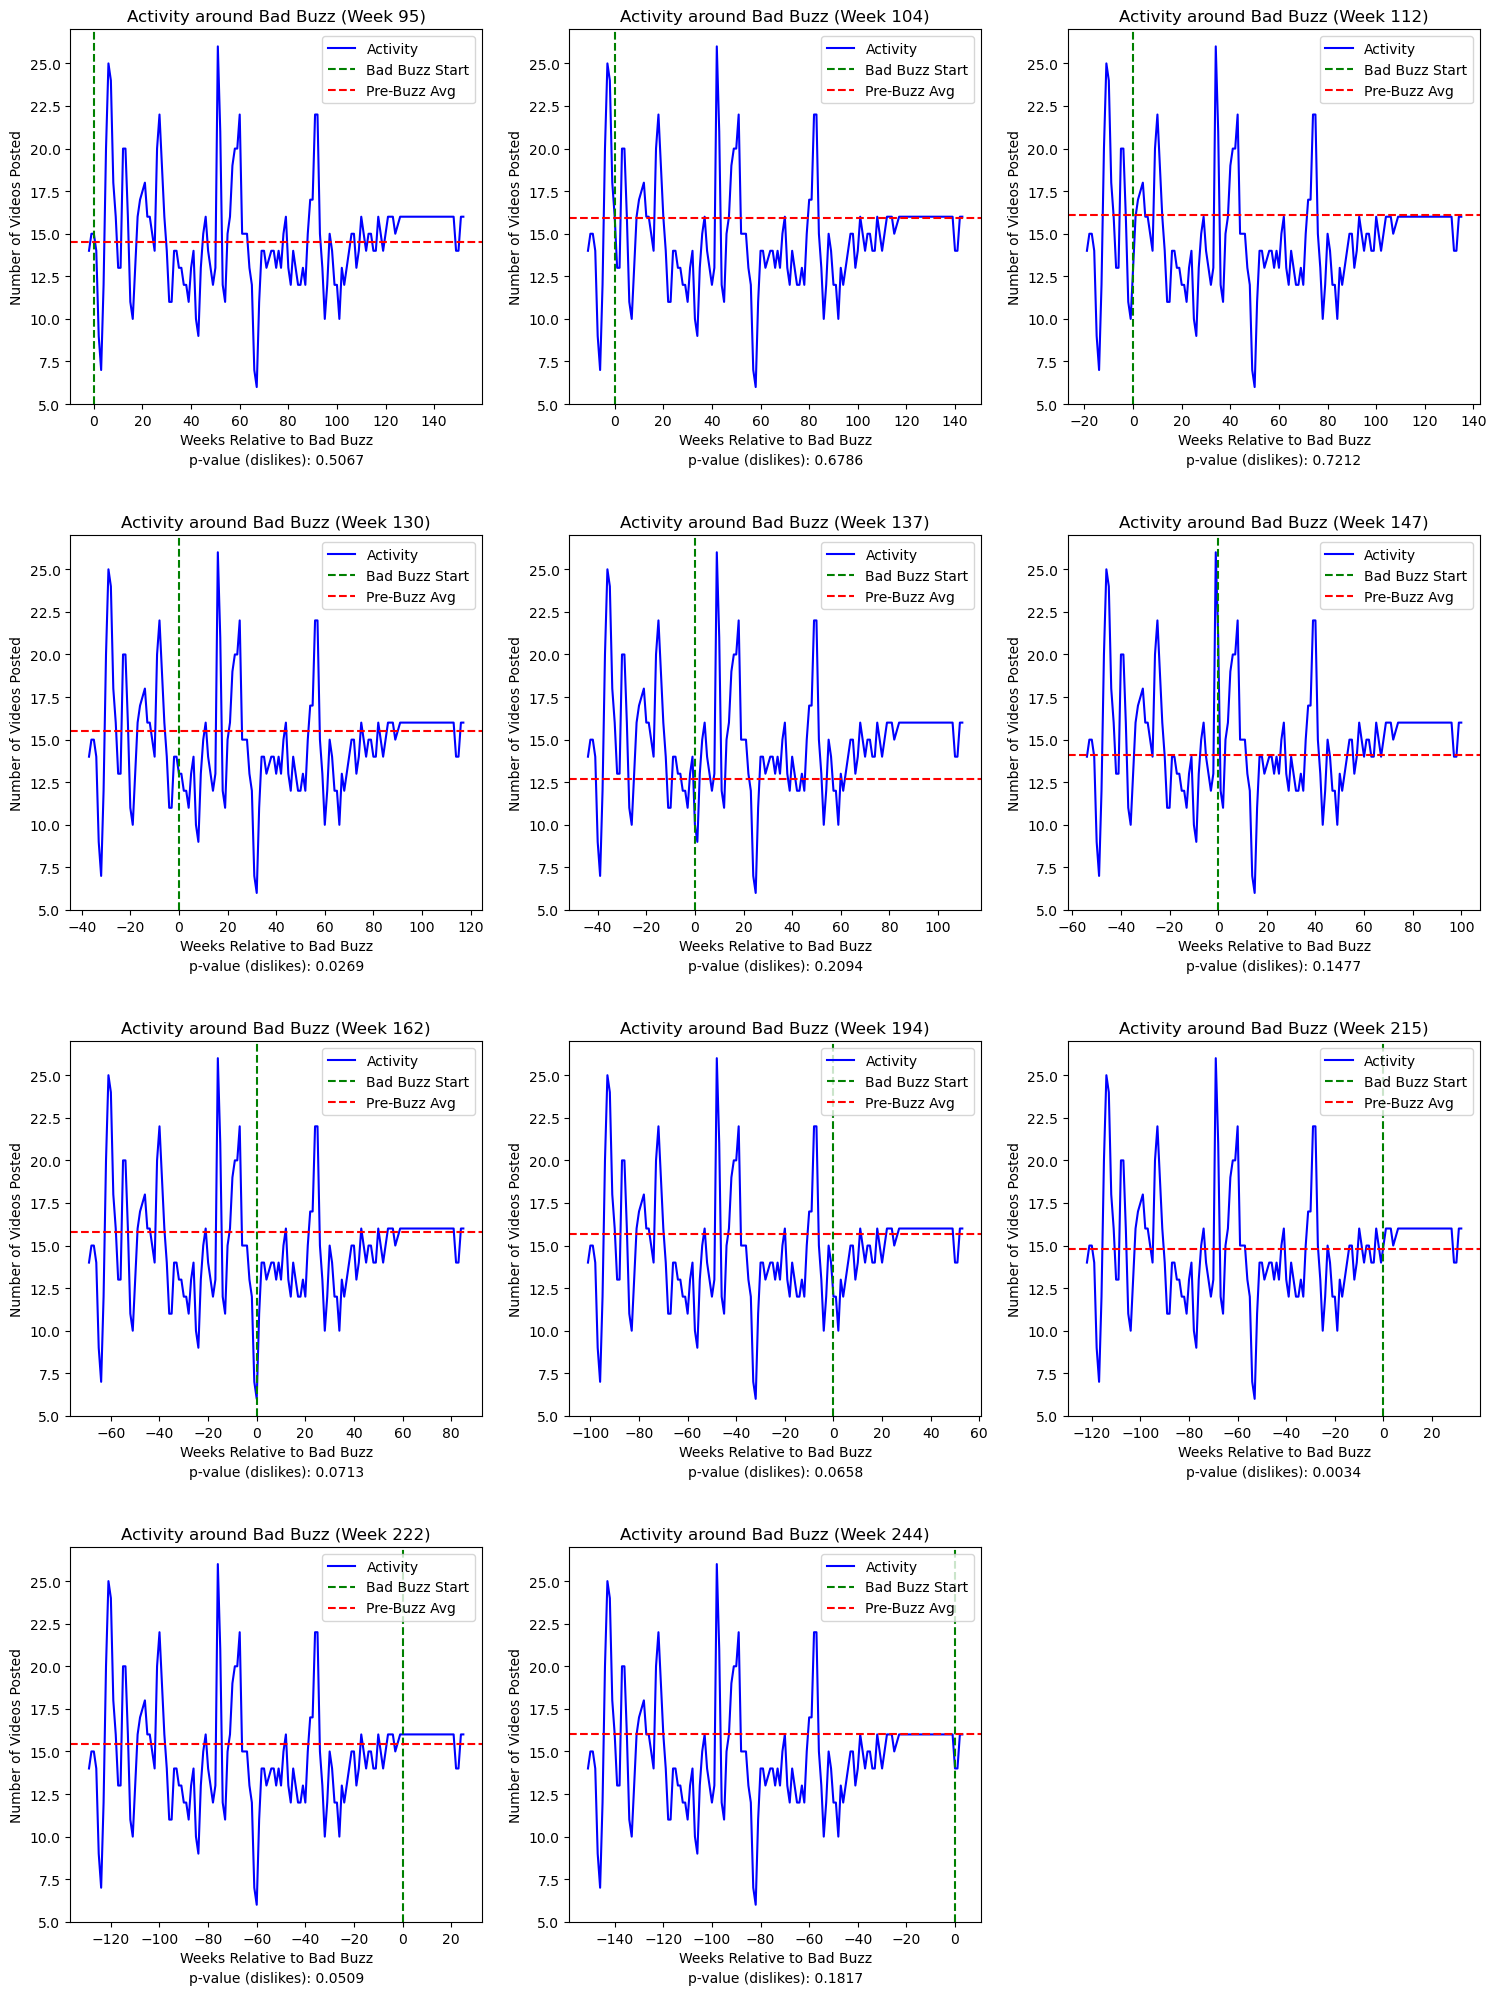

In [17]:
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.")

fig, axes = plt.subplots(4, 3, figsize=(15, 20))

axes = axes.flatten()

for i, week in enumerate(pew_die_pie_bb_weeks):
    df_plot = normalize_week_indices(pew_die_pie, week)
    pre_buzz, during_buzz, post_buzz = define_periods(df_plot)
    avg_pre_activity, avg_during_activity, avg_post_activity = calculate_activity_averages(pre_buzz, during_buzz, post_buzz)
    
    p_value_activity = perform_activity_t_tests(pre_buzz, during_buzz)
    
    plot_activity_results(axes[i], df_plot, avg_pre_activity, week, p_value_activity)
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(hspace=0.35)
plt.show()

When looking at these plots, we can see that the p-values of some of the events represented are very low (for example during weeks 130 or 215), suggesting that there might be a correlation between these channel's growth and their activity. Nonetheless, the graphs shown above are difficult to interpret since there is no clear pattern in the activity of the channel around the periods of interest.\
We could have a better understanding of the trends of the activity around periods of slow growth by also performing t-tests with different time periods: one the week before the start of the detected periods and one the few weeks before, in order to see if a lower activity might be correlated with a lower growth rate.

### 2. For All Channels 

In [18]:
interactive_plot_activity = widgets.interactive_output(analyze_activity_around_bad_buzz, {'channel': channel_selector, 
                                                                                          'df': widgets.fixed(data), 
                                                                                          'bad_buzz_df': widgets.fixed(bad_buzz_df)})
display(channel_selector, interactive_plot_activity)

SelectionSlider(description='Channel:', options=('UC-lHJZR3Gqxm24_Vd_AJ5Yw', 'UC0v-tlzsn0QZwJnkiaUSJVQ', 'UC1r…

Output()

We create a dataframe containing the channels, their categories and the events of growth drop.

In [19]:
bad_buzz_df = bad_buzz_df.rename(columns={'week': 'event'})
df_merge = bad_buzz_df.merge(data.reset_index(), on='channel')
df_merge = df_merge.set_index(['channel', 'week'])
df_merge

event        category         views  \
channel                  week                                        
UC-lHJZR3Gqxm24_Vd_AJ5Yw 93       95          Gaming  1.357761e+10   
                         94       95          Gaming  1.368959e+10   
                         95       95          Gaming  1.373594e+10   
                         96       95          Gaming  1.376195e+10   
                         97       95          Gaming  1.378603e+10   
...                              ...             ...           ...   
UCzKc6JrWSt_67UpEYIefrJQ 243     244  People & Blogs  1.060344e+08   
                         244     244  People & Blogs  1.061163e+08   
                         245     244  People & Blogs  1.061940e+08   
                         246     244  People & Blogs  1.062897e+08   
                         247     244  People & Blogs  1.063659e+08   

                                delta_views          subs     delta_subs  \
channel                  week                                              
UC-lHJZR3Gqxm24_Vd_AJ5Yw 93             NaN  4.861796e+07            NaN   
                         94    1.119836e+08  4.897182e+07  353856.680699   
                         95    4.635159e+07  4.909397e+07  122152.626592   
                         96    2.600902e+07  4.917638e+07   82404.010417   
                         97    2.407718e+07  4.925474e+07   78360.625000   
...                                     ...           ...            ...   
UCzKc6JrWSt_67UpEYIefrJQ 243   1.160609e+05  2.142763e+06    1756.125000   
                         244   8.184225e+04  2.143576e+06     812.875000   
                         245   7.769925e+04  2.140923e+06   -2652.875000   
                         246   9.572875e+04  2.140000e+06    -923.000000   
                         247   7.618318e+04  2.140000e+06       0.000000   

                               videos  delta_videos  activity  view_count  \
channel                  week                                               
UC-lHJZR3Gqxm24_Vd_AJ5Yw 93      2906           NaN        14  45210757.0   
                         94      2919          13.0        15  40885232.0   
                         95      2926           7.0        15  27707359.0   
                         96      2932           6.0        14  25489724.0   
                         97      2934           2.0         9  10034755.0   
...                               ...           ...       ...         ...   
UCzKc6JrWSt_67UpEYIefrJQ 243      259           0.0         0         0.0   
                         244      259           0.0         0         0.0   
                         245      259           0.0         0         0.0   
                         246      259           0.0         0         0.0   
                         247      259           0.0         0         0.0   

                               like_count  dislike_count  rolling_growth_rate  \
channel                  week                                                   
UC-lHJZR3Gqxm24_Vd_AJ5Yw 93     1892943.0        51248.0                  NaN   
                         94     2018614.0        35580.0        353856.680699   
                         95     1390650.0        22598.0        238004.653646   
                         96     1261334.0        38704.0        186137.772569   
                         97      514876.0        19313.0        159193.485677   
...                                   ...            ...                  ...   
UCzKc6JrWSt_67UpEYIefrJQ 243          0.0            0.0          1215.675000   
                         244          0.0            0.0          1286.093750   
                         245          0.0            0.0          1185.500000   
                         246          0.0            0.0          1172.637500   
                         247          0.0            0.0          1199.850000   

                                 growth_diff  is_bad_buzz  
channel        

### Total Number of Events by Category
We are plotting the number of events where the growth rate of a channel decreases abruptly by channel category in order to see if some categories are more prone to experience sudden changes of `delta_subs`.

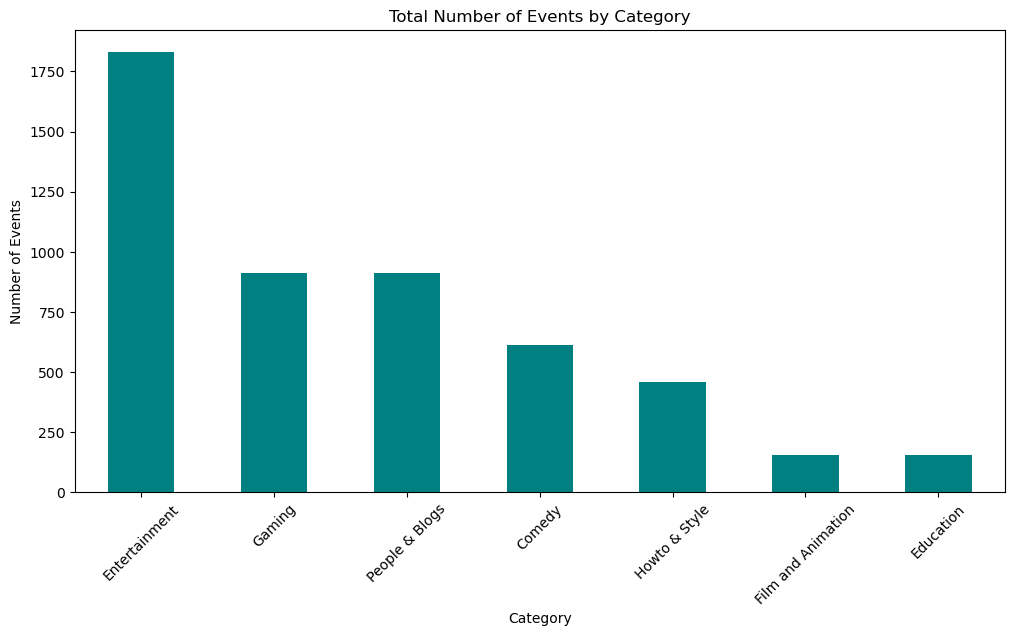

In [20]:
category_counts = data['category'].value_counts()
plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar', color='teal')
plt.title('Total Number of Events by Category')
plt.xlabel('Category')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.show()

We can observe that the category `Entertainment` is the category with the most important number of growth rate drops.\
The `Film and Animation` and the `Education` channels are the categories with the fewest negative events observed.

# III. Data Analysis On All Dataset 

## Data Processing

In [22]:
original_data

category         views   delta_views  \
channel                  week                                                
UC--24Q3_ZQeFmgJE-Um5QZQ 82    Travel & Events  6.252450e+04           NaN   
                         83    Travel & Events  6.760025e+04   5075.750000   
                         84    Travel & Events  6.998200e+04   2381.750000   
                         85    Travel & Events  7.266312e+04   2681.125000   
                         86    Travel & Events  7.509300e+04   2429.875000   
...                                        ...           ...           ...   
UCzzzZ3-icktxbC3j7hkWqRw 243     Howto & Style  1.068225e+07  97305.600000   
                         244     Howto & Style  1.075932e+07  77068.254545   
                         245     Howto & Style  1.083125e+07  71936.345455   
                         246     Howto & Style  1.089879e+07  67538.800000   
                         247     Howto & Style  1.096662e+07  67823.542857   

                                        subs   delta_subs  videos  \
channel                  week                                       
UC--24Q3_ZQeFmgJE-Um5QZQ 82      1466.000000          NaN      29   
                         83      1508.625000    42.625000      30   
                         84      1530.750000    22.125000      31   
                         85      1558.625000    27.875000      32   
                         86      1591.000000    32.375000      33   
...                                      ...          ...     ...   
UCzzzZ3-icktxbC3j7hkWqRw 243   115142.400000  1019.200000      43   
                         244   115886.363636   743.963636      43   
                         245   116508.000000   621.636364      43   
                         246   116938.500000   430.500000      43   
                         247   117857.142857   918.642857      43   

                               delta_videos  activity  view_count  like_count  \
channel                  week                                                   
UC--24Q3_ZQeFmgJE-Um5QZQ 82             NaN         1      5849.0       222.0   
                         83             1.0         2      5336.0       204.0   
                         84             1.0         2      5727.0       232.0   
                         85             1.0         2     19214.0       318.0   
                         86             1.0         2      6949.0       234.0   
...                                     ...       ...         ...         ...   
UCzzzZ3-icktxbC3j7hkWqRw 243            0.0         0         0.0         0.0   
                         244            0.0         0         0.0         0.0   
                         245            0.0         0         0.0         0.0   
                         246            0.0         0         0.0         0.0   
                         247            0.0         0         0.0         0.0   

                               dislike_count  
channel                  week                 
UC--24Q3_ZQeFmgJE-Um5QZQ 82              1.0  
                         83              1.0  
                         84              1.0  
                         85              7.0  
                         86              1.0  
...                                      ...  
UCzzzZ3-icktxbC3j7hkWqRw 243             0.0  
                         244             0.0  
                         245             0.0  
                         246             0.0  
                         247             0.0  

[18604824 rows x 11 columns]

In [23]:
# ROLLING_WINDOW = 20

# # original_data['rolling_growth_rate'] = original_data.groupby('channel')['delta_subs'].transform(lambda x: x.rolling(ROLLING_WINDOW, min_periods=1).mean())

# # Initialize an empty DataFrame to store the results
# result = pd.DataFrame()

# # Iterate over each group with a progress bar
# for name, group in tqdm(original_data.groupby('channel'), desc="Processing channels"):
#     group['rolling_growth_rate'] = group['delta_subs'].rolling(ROLLING_WINDOW, min_periods=1).mean()
#     result = pd.concat([result, group])

# # Assign the result back to the original_data
# original_data = result

In [24]:
# original_data['growth_diff'] = original_data['delta_subs'] - original_data['rolling_growth_rate']

# # Detection of period where growth_rate < rolling_growth_rate
# original_data['is_bad_buzz'] = original_data['growth_diff'] < 0

# # Create a DataFrame that contains only the starting week of each BBC
# bad_buzz_starts = []

# # For loop to detect the starting week of BB
# for channel in original_data.reset_index()['channel'].unique():
#     channel_data = original_data.reset_index()[original_data.reset_index()['channel'] == channel]
    
#     # Identify indices where BB has started
#     for i in range(1, len(channel_data)):
#         if channel_data['is_bad_buzz'].iloc[i] and not channel_data['is_bad_buzz'].iloc[i-1]:
#             bad_buzz_starts.append({'channel': channel, 'week': channel_data['week'].iloc[i]})

# bad_buzz_odf = pd.DataFrame(bad_buzz_starts).reset_index()[['channel', 'week']]

# original_data.reset_index().to_csv('df_with_rgr.tsv', sep='\t', index=False)
# bad_buzz_odf.to_csv('event.tsv', sep = '\t', index = False)

In [25]:
df_with_rgr = pd.read_csv('Data/df_with_rgr.tsv', sep='\t')
events= pd.read_csv('Data/event.tsv', sep='\t')
df_with_rgr.head()

,category,views,delta_views,subs,delta_subs,videos,delta_videos,activity,view_count,like_count,dislike_count,rolling_growth_rate,growth_diff,is_bad_buzz
0,Travel & Events,62524.500,NaN,1466.000,NaN,29,NaN,1,5849.0,222.0,1.0,NaN,NaN,False
1,Travel & Events,67600.250,5075.750,1508.625,42.625,30,1.0,2,5336.0,204.0,1.0,42.625,0.000,False
2,Travel & Events,69982.000,2381.750,1530.750,22.125,31,1.0,2,5727.0,232.0,1.0,32.375,-10.250,True
3,Travel & Events,72663.125,2681.125,1558.625,27.875,32,1.0,2,19214.0,318.0,7.0,30.875,-3.000,True
4,Travel & Events,75093.000,2429.875,1591.000,32.375,33,1.0,2,6949.0,234.0,1.0,31.250,1.125,False


In [26]:
df_with_rgr.index = original_data.index

## A. Various Plots
We show different plots to have a more comprehensive view of the dataset, and to find interesting relationships that could be further investigated during the third part of the project.

### Delta Subs by Category
We expect the channel category to play a role in content strategy and expectations for channel performance

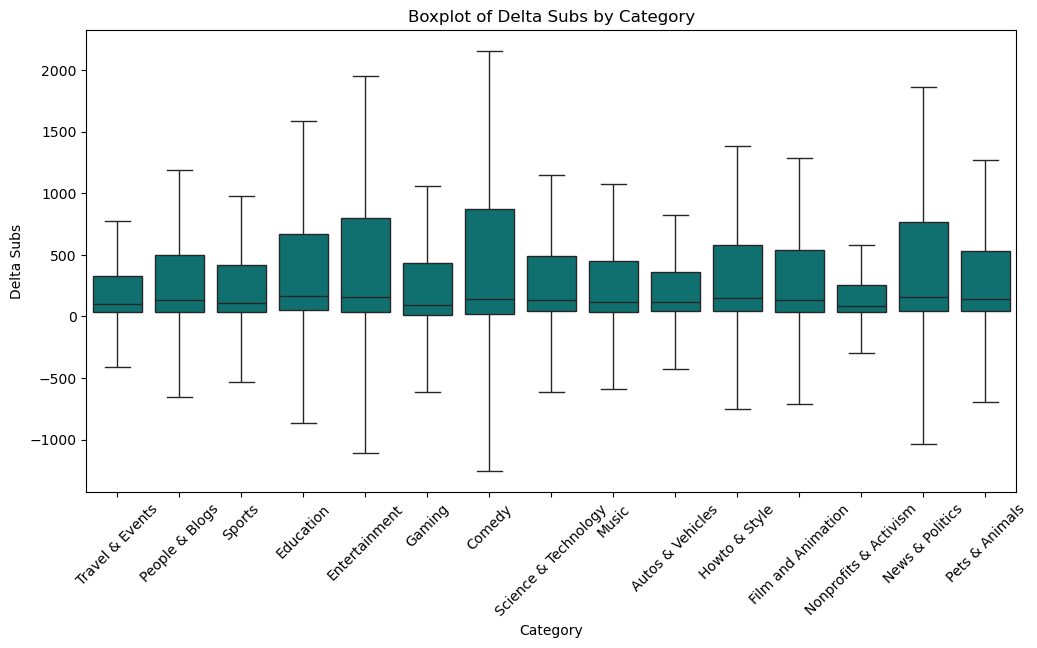

In [27]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_with_rgr, x='category', y='delta_subs', color='teal', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Delta Subs by Category')
plt.xlabel('Category')
plt.ylabel('Delta Subs')
plt.show()

`People & Blogs` has the widest spread, indicating that channels in this category can have large variations in subscriber gains or losses.\
Other categories like `Gaming` and `Film and Animation` have relatively smaller interquartile ranges, suggesting more consistent subscriber changes.\
`Education` shows minimal variability and a lower median change, suggesting that channels in this category typically experience smaller changes in subscribers.

### Distribution of Growth Rate Declines Over Time


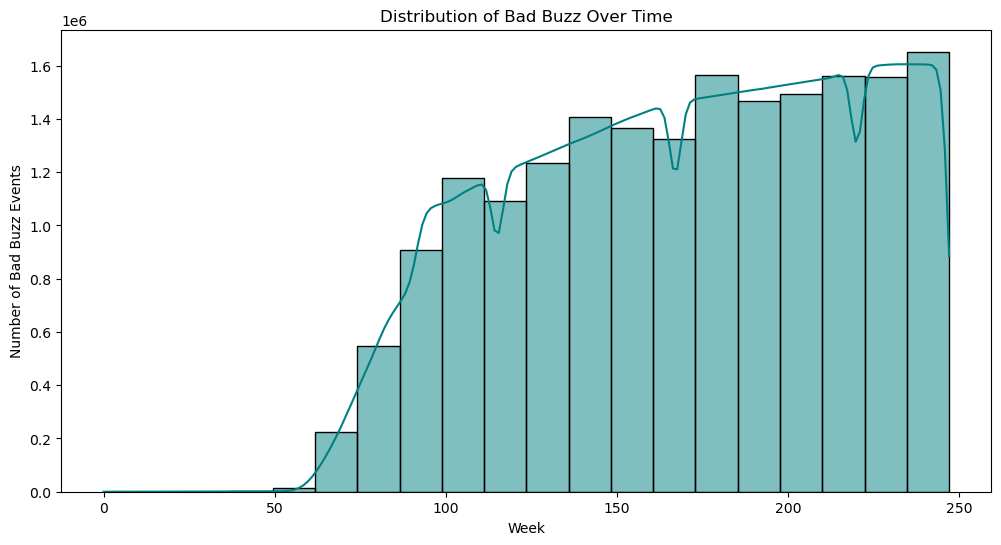

In [28]:
plt.figure(figsize=(12, 6))
sns.histplot(df_with_rgr.reset_index()['week'], bins=20, kde=True, color='teal')
plt.title('Distribution of Bad Buzz Over Time')
plt.xlabel('Week')
plt.ylabel('Number of Bad Buzz Events')
plt.show()

This plot can reveal whether there is a cyclical pattern in the occurrence of our periods of interest. However, in our dataset, such a trend is not evident, as the peaks do not seem to recur at consistent times of the year.


### Correlation Matrix
This matrix allows to identify relationships between numerical features.

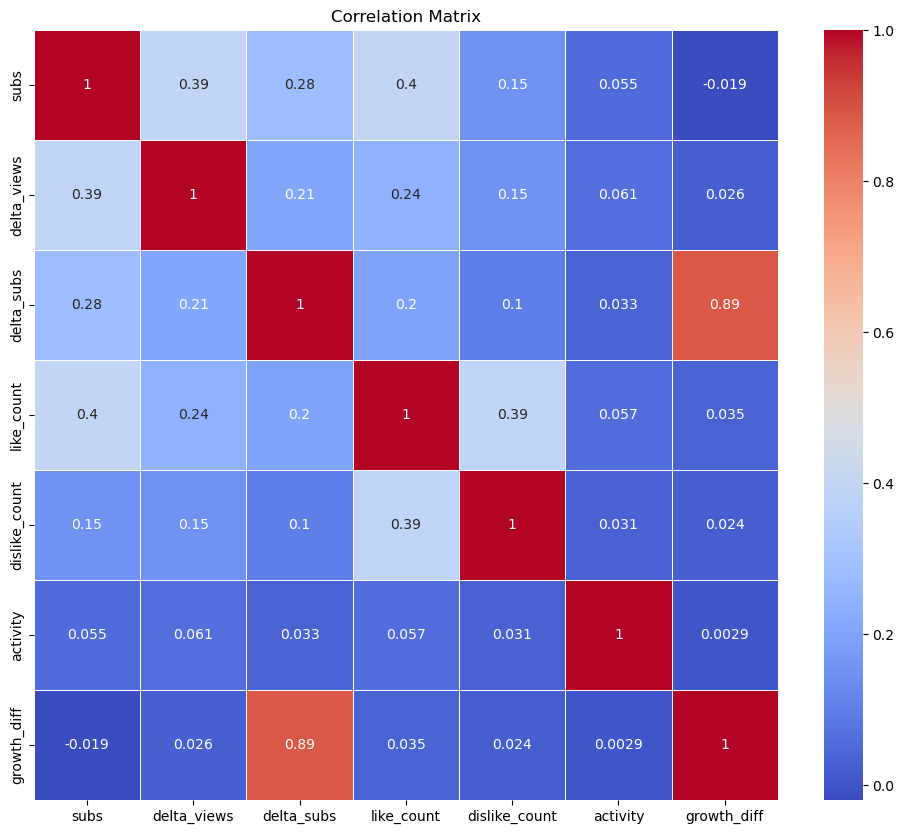

In [29]:
plt.figure(figsize=(12, 10))
selected_columns = ['subs','delta_views', 'delta_subs', 'like_count', 'dislike_count', 'activity', 'growth_diff']
numeric_df = df_with_rgr[selected_columns]  # Select only the specific columns

sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

When analyzing this matrix, we notice the following correlations:
- High Positive Correlations:
    - `like_count` and `subs` (0.73): There is a strong positive correlation, as the number of likes increases, the number of subscribers also tends to increase.
    - `delta_subs` and `like_count` (0.68): A positive relationship between changes in subscriber counts and the number of likes indicates that more likes might accompany subscriber growth.

- Lower Correlations:
    - `dislike_count` has lower correlations with most metrics, indicating that dislikes may not be strongly related to other growth metrics in this dataset.
    - `growth_diff` shows minimal correlation with most columns except delta_subs, hinting that it might capture unique aspects of growth fluctuation that are less related to likes, activity, or views.

In order to understand audience engagement, the columns showing high correlations with `subs` and `delta_subs` are particularly insightful.

### Scatterplot of Activity vs Subscriber Growth
We want to investigate if higher activity correlates with better subscriber growth.

KeyboardInterrupt: 

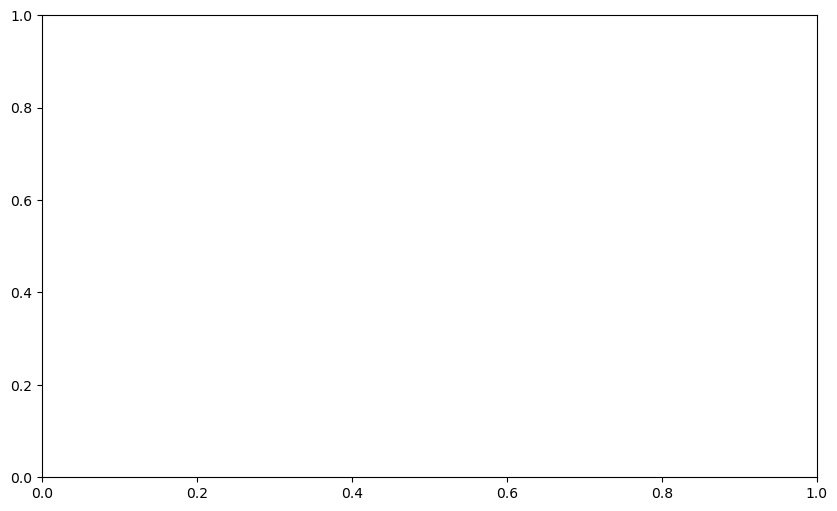

In [30]:
# TODO Faire ouverture sur la èossibilité de faire un modèle qui détecte les bb avec les metrics de la partie II
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_with_rgr, x='activity', y='delta_subs', hue='category')
plt.title('Activity vs. Subscriber Growth')
plt.xlabel('Activity')
plt.ylabel('Delta Subs')
plt.show()

We can see that the activity seem to be positively related to the subscriber growth, but this relation depends on the channel category: it is the strongest for `Gaming` channels, when the growth of `Howto & Style` or `Education` channels doesn't seem to be related to the activity of the channels.

In [ ]:
# TODO Analyser ce plot, sinon le retirer
sns.pairplot(df_with_rgr, vars=['views', 'delta_views', 'subs', 'delta_subs', 'activity'])
plt.show()

Note: From this point onward, not all plots will be displayed. We discovered late in the process that our DataFrame `events` was not created properly. Unfortunately, we did not have enough time to recreate it, as the process takes at least 800 minutes.

## B. Subscribers Analysis

### 1. Subscribers plot for each channel

In [ ]:
# Create a SelectionSlider widget for selecting channels
channel_selector_original = SelectionSlider(
    options=df_with_rgr.index.get_level_values('channel').unique(),
    description='Channel:',
    disabled=False
)
interactive_plot_original = widgets.interactive_output(plot_subs_by_channel, {'channel': channel_selector_original, 'df': widgets.fixed(df_with_rgr)})
display(channel_selector_original, interactive_plot_original)

SelectionSlider(description='Channel:', options=('UC--24Q3_ZQeFmgJE-Um5QZQ', 'UC--2EbuIuBOGgGqPiJxi3rg', 'UC--…

Output()

### 2. Rolling average analysis 

In [ ]:
channel_selector_original = SelectionSlider(
    options=df_with_rgr.index.get_level_values('channel').unique(),
    description='Channel:',
    disabled=False
)

In [ ]:
# TODO Remettre les fichiers .tsv au bon endroit dans le repository
interactive_plot_subs_roll_avg_original = widgets.interactive_output(plot_rolling_growth_rate, {'channel': channel_selector_original, 
                                                                                                'df': widgets.fixed(df_with_rgr), 
                                                                                                'bad_buzz_df': widgets.fixed(events)})
display(channel_selector_original, interactive_plot_subs_roll_avg_original)

SelectionSlider(description='Channel:', options=('UC--24Q3_ZQeFmgJE-Um5QZQ', 'UC--2EbuIuBOGgGqPiJxi3rg', 'UC--…

Output()

## C. Views Analysis around Detected BB

### 1. Delta Views Evolution In General

In [ ]:
interactive_plot_views_original = widgets.interactive_output(plot_views_around_bad_buzz, {'channel': channel_selector_original, 
                                                                                        'df': widgets.fixed(df_with_rgr), 
                                                                                        'bad_buzz_df': widgets.fixed(events)})
display(channel_selector_original, interactive_plot_views_original)

SelectionSlider(description='Channel:', options=('UC--24Q3_ZQeFmgJE-Um5QZQ', 'UC--2EbuIuBOGgGqPiJxi3rg', 'UC--…

Output()

### 2. Delta Views Evolution in around BB

SelectionSlider(description='Channel:', options=('UC--24Q3_ZQeFmgJE-Um5QZQ', 'UC--2EbuIuBOGgGqPiJxi3rg', 'UC--…

Output()

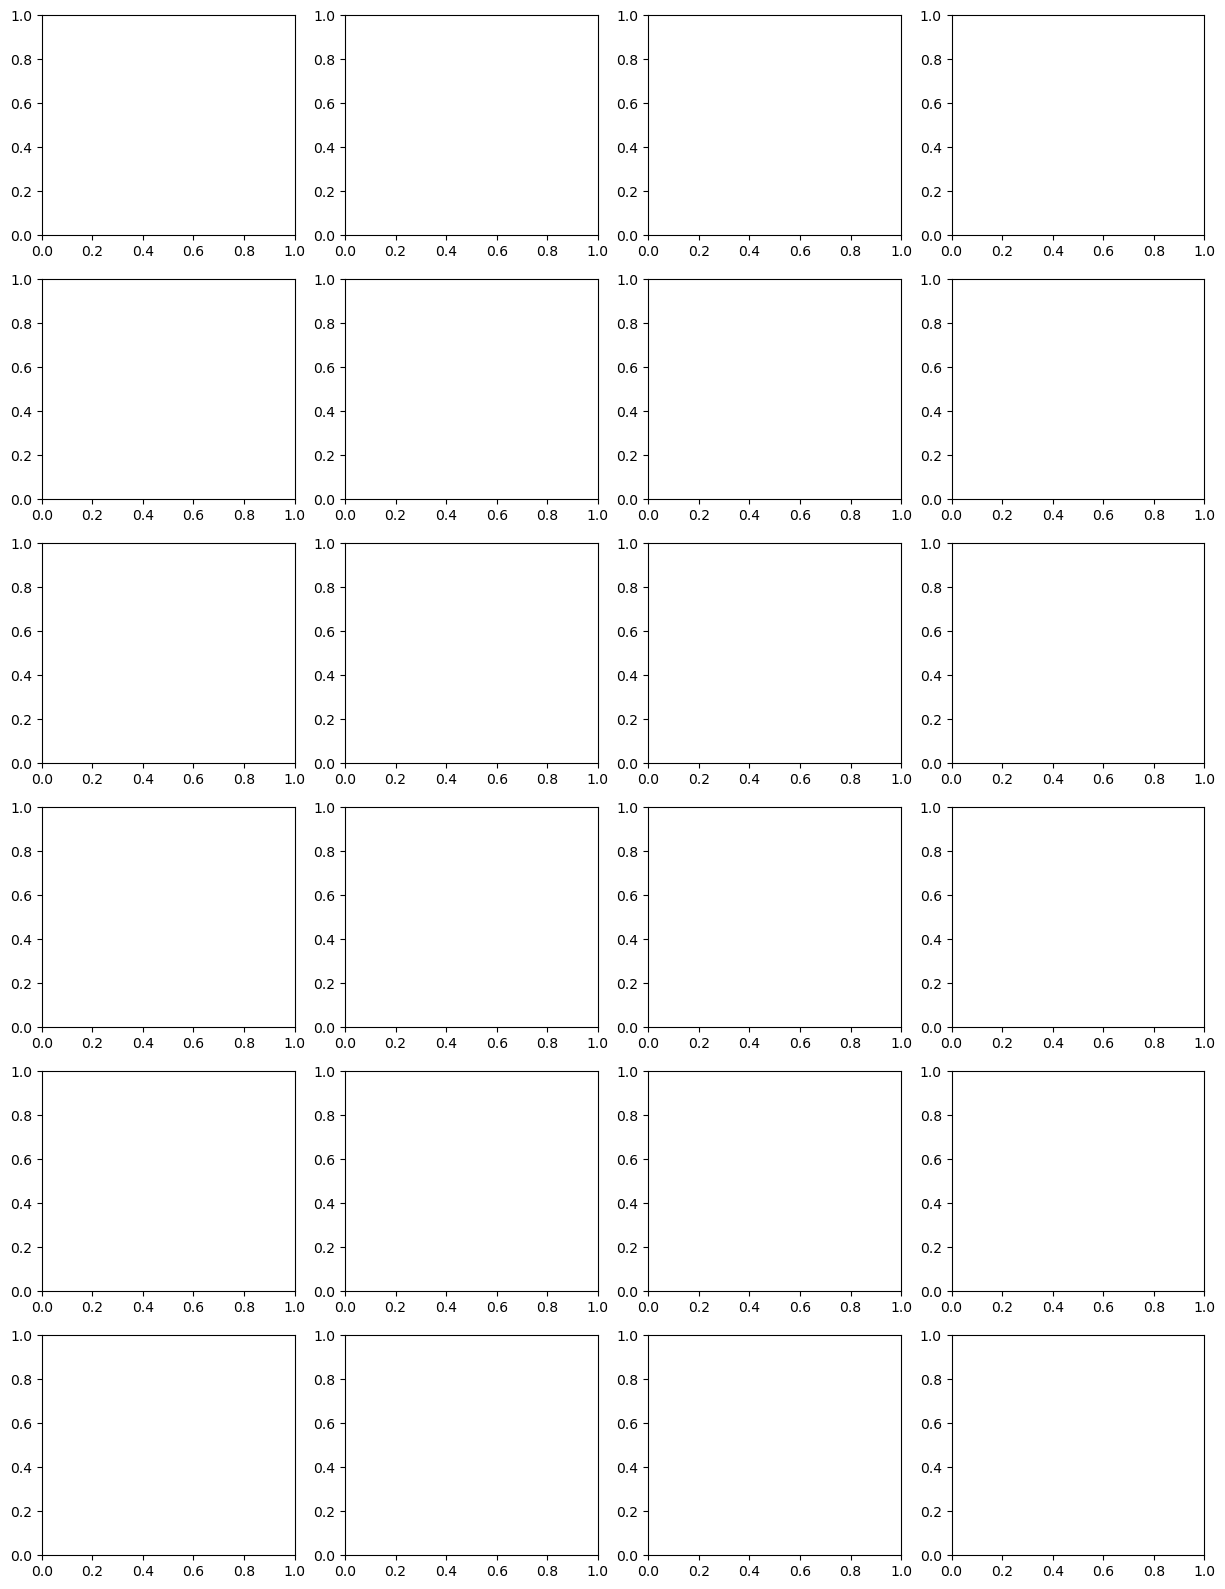

In [ ]:
interactive_plot_views_roll_avg_original = widgets.interactive_output(analyze_views_around_bad_buzz, {'channel': channel_selector_original, 
                                                                                                    'df': widgets.fixed(df_with_rgr), 
                                                                                                    'bad_buzz_df': widgets.fixed(events)})
display(channel_selector_original, interactive_plot_views_roll_avg_original)

## D. Likes/Dislikes Analysis

SelectionSlider(description='Channel:', options=('UC--24Q3_ZQeFmgJE-Um5QZQ', 'UC--2EbuIuBOGgGqPiJxi3rg', 'UC--…

Output()

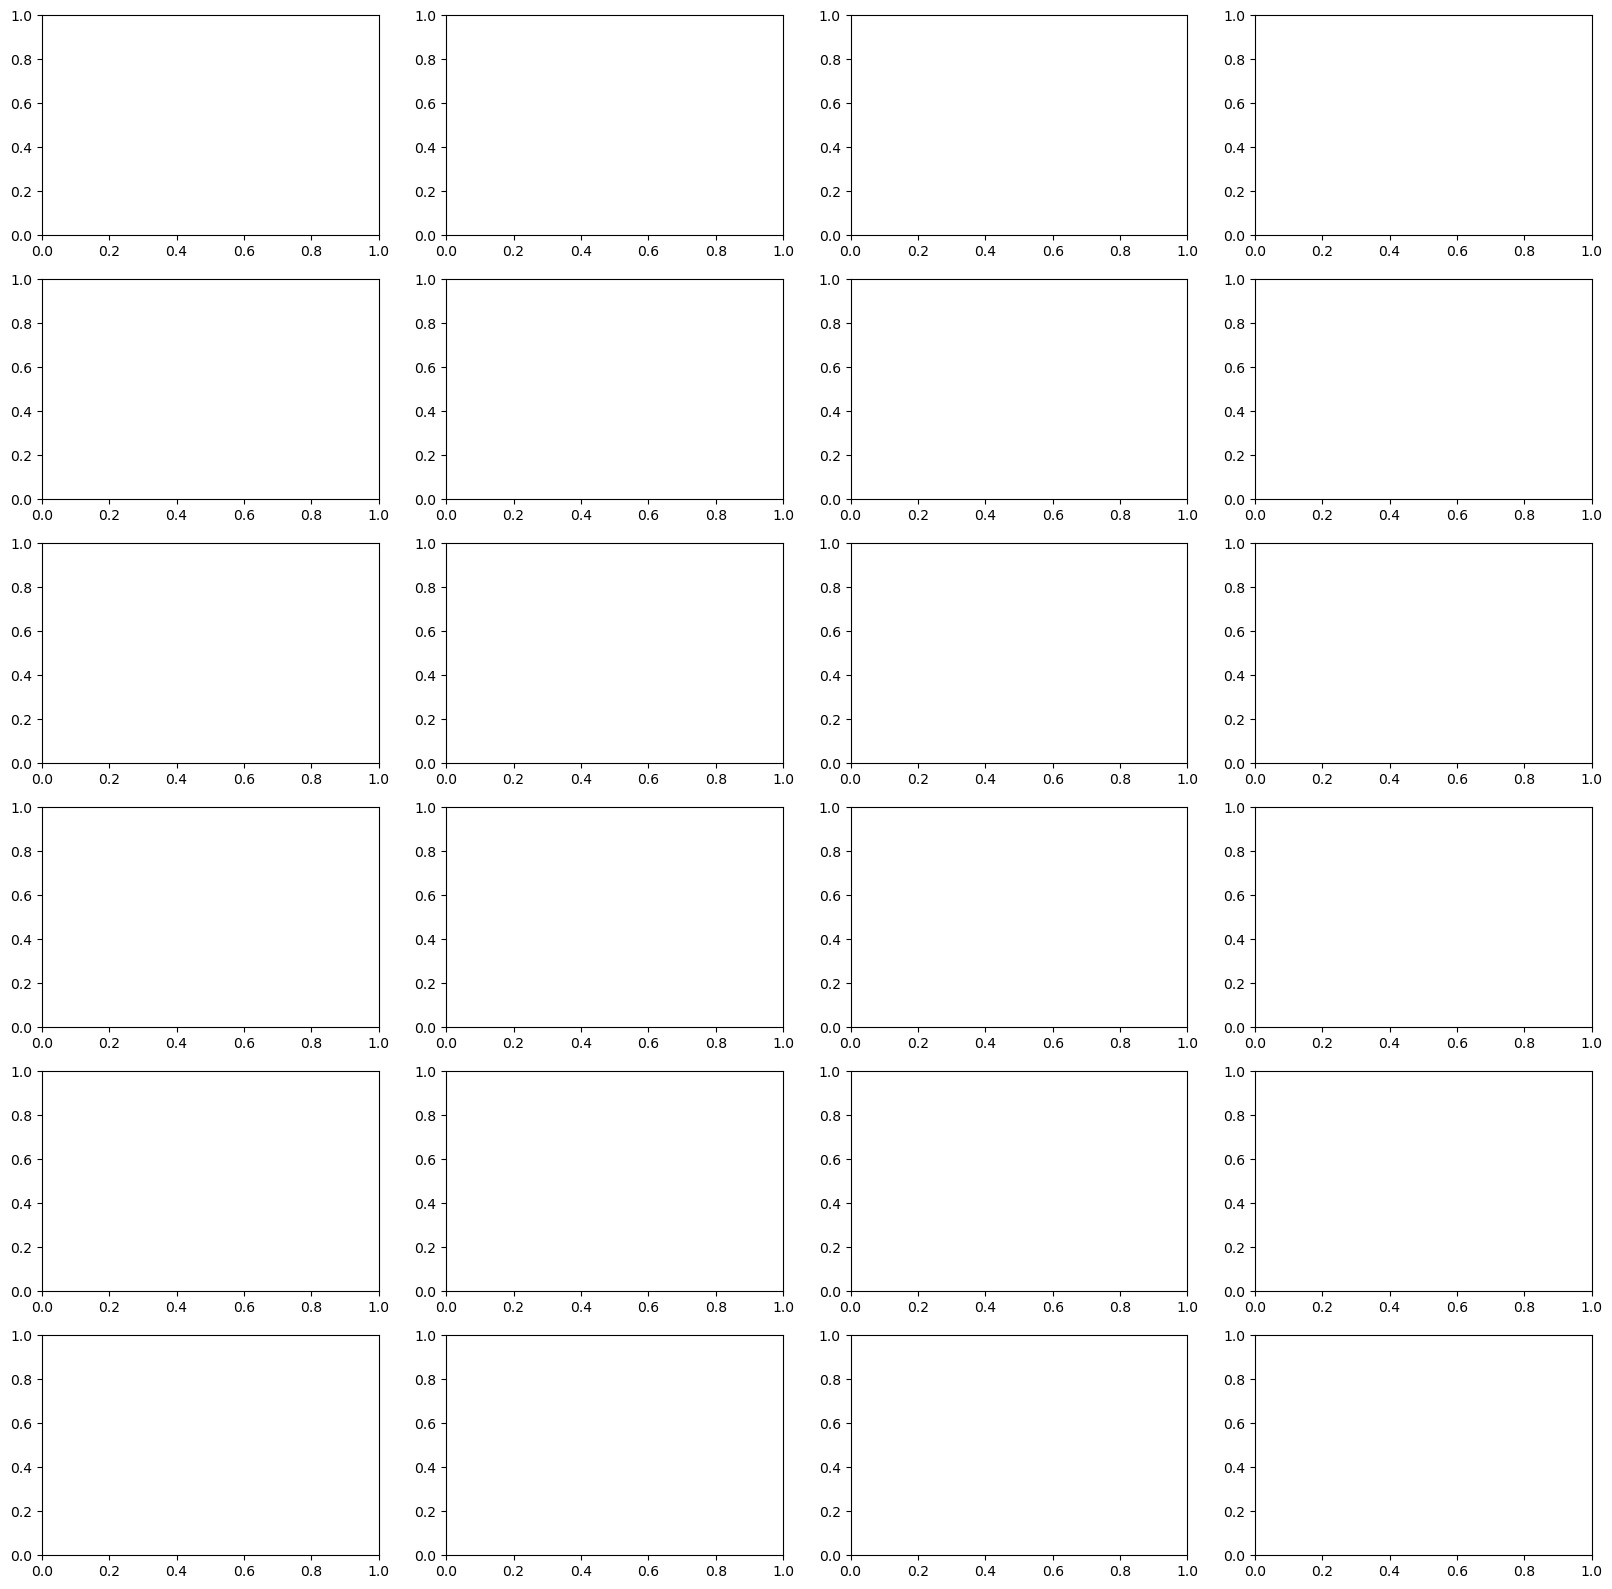

In [ ]:
interactive_plot_likes_dislikes_original = widgets.interactive_output(analyze_engagement_around_bad_buzz, {'channel': channel_selector_original, 
                                                                                                            'df': widgets.fixed(df_with_rgr), 
                                                                                                            'bad_buzz_df': widgets.fixed(events)})
display(channel_selector_original, interactive_plot_likes_dislikes_original)

## E. Activity Analysis

SelectionSlider(description='Channel:', options=('UC--24Q3_ZQeFmgJE-Um5QZQ', 'UC--2EbuIuBOGgGqPiJxi3rg', 'UC--…

Output()

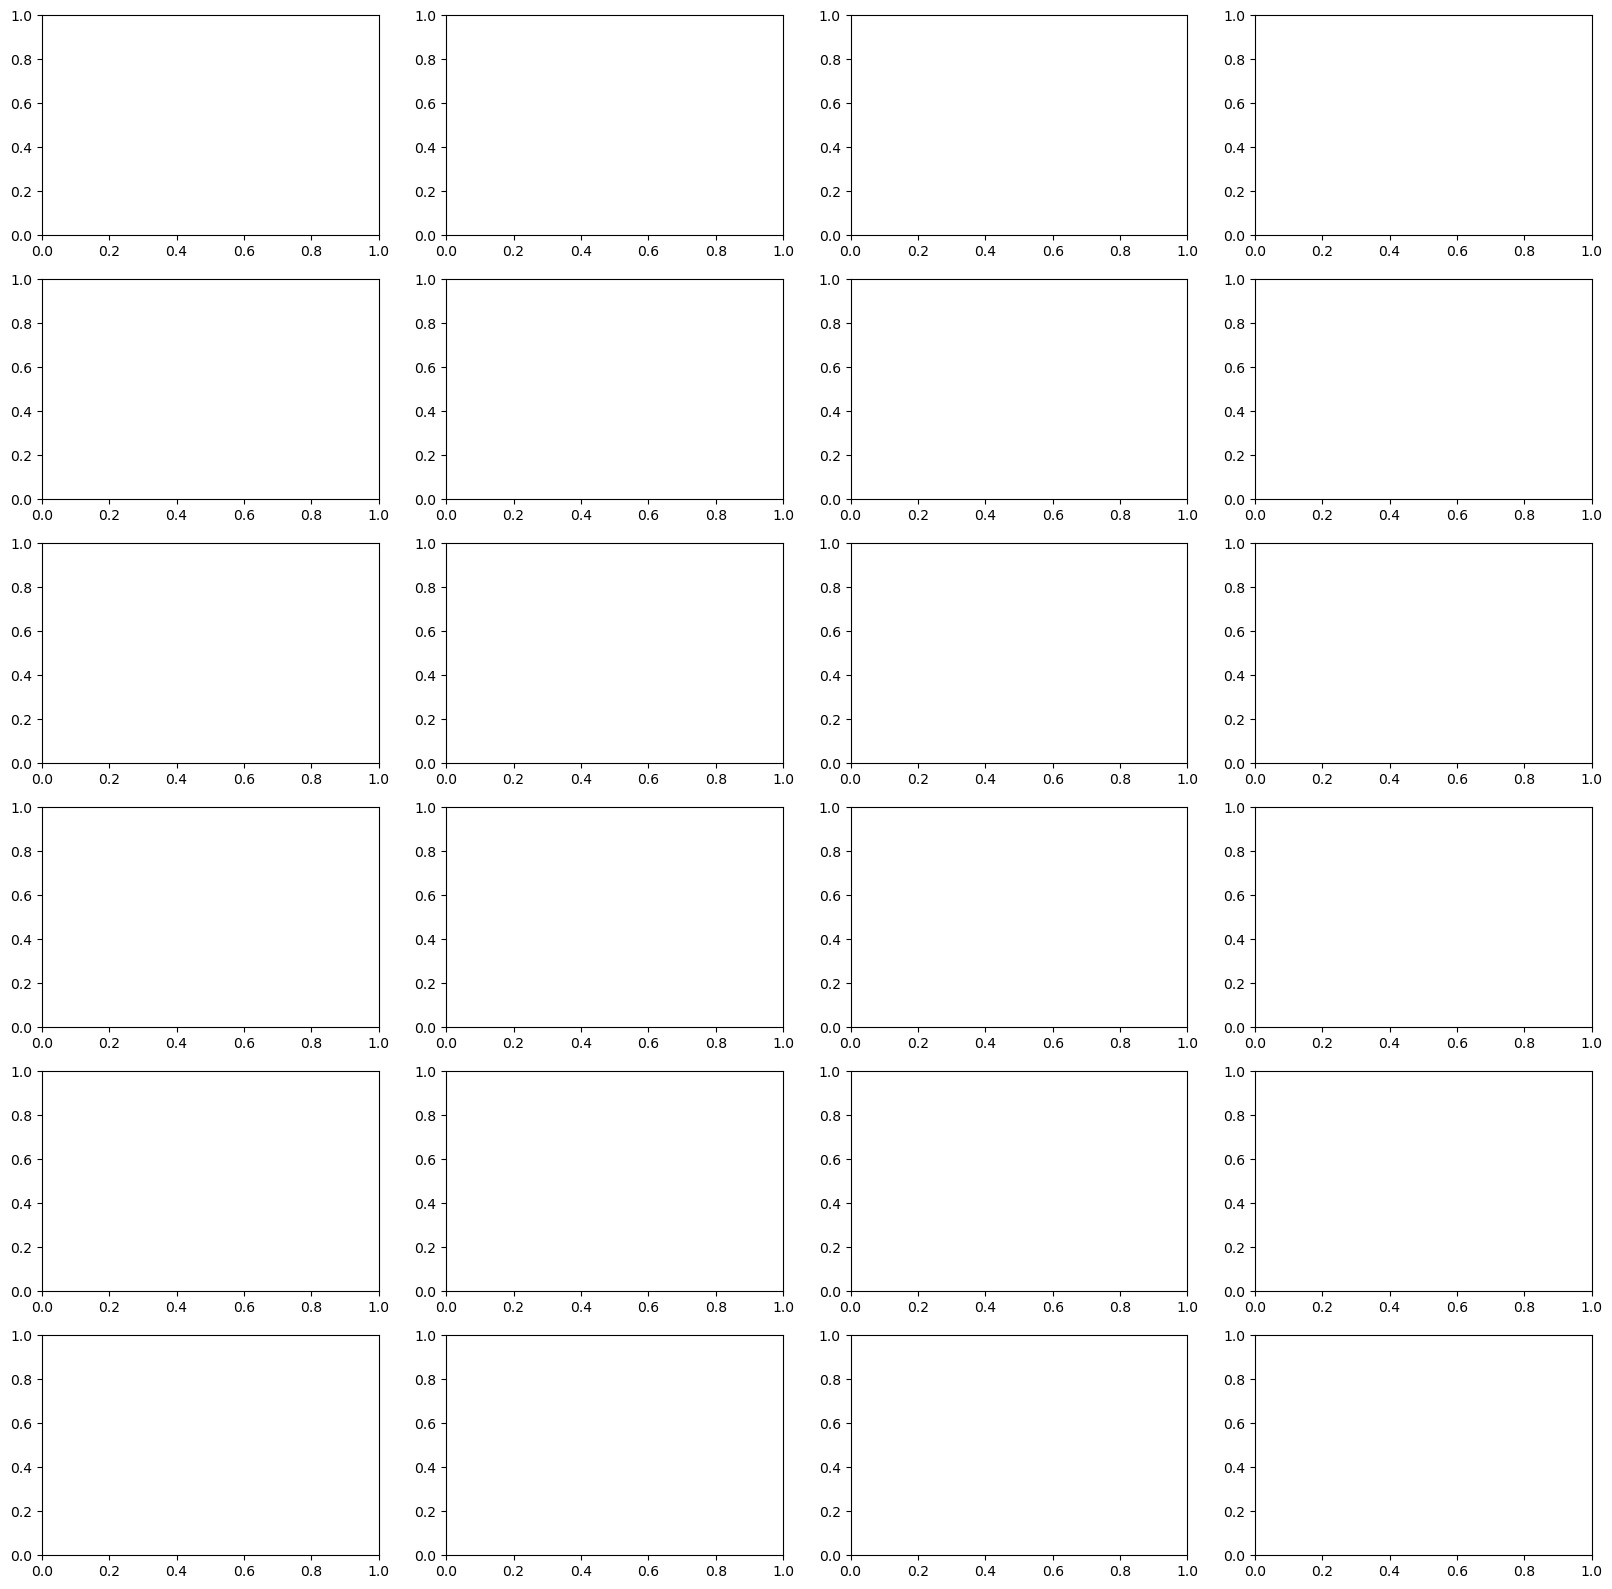

In [ ]:
interactive_plot_activity_original = widgets.interactive_output(analyze_activity_around_bad_buzz, {'channel': channel_selector_original, 
                                                                                                    'df': widgets.fixed(df_with_rgr), 
                                                                                                    'bad_buzz_df': widgets.fixed(events)})
display(channel_selector_original, interactive_plot_activity_original)